In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

In [283]:
# Paths
data_path_preproc = '/media/moor-data/preprocessed.new/'
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'npinsert_ecog_decoding_all'

subject = 'beignet'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']

In [3]:
good_unit_labels = {}

### Quality metric parameters ###
# 1. Presence Ratio
epoch_size = 10 # [s]
min_trial_prop = 0.85 # presence ratio threshold to classify a unit as a good unit

# 2. Firing Rate
fr_trial_window_size=17

# 3. ISI violations
min_refractory_period = 1 # [ms]
isi_perc_thresh = 0.02
isi_count_thresh = 100

# Load data

## Load preprocessed data to run quality metrics on

In [17]:
np_data = {}
start = time.time()
for align_event in align_events:
    np_data[align_event] = aopy.data.base.pkl_read(f"{subject}_{align_event}", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = len(np_data[align_event]['spike_align'])
recording_site = np_data[align_event]['recording_site'] # will be the same for all align events

3.0 min to load preprocessed data


In [18]:
# TODO move this to preprocessing
for align_event in align_events:
    np_data[align_event]['target_idx_good'] = []
    for irec in range(nrecs):
        np_data[align_event]['target_idx_good'].append(np_data[align_event]['target_idx'][irec][np_data[align_event]['good_trial_idx'][irec]])

# ntrials_by_target = [[np.sum(target_idx_good[id]==itarget+1) for itarget in range(ntargets)] for id in range(len(dates))]
# unit_total_fr = [[len(spike_times[idate][str(unit_labels[idate][iunit])])/(np.max(spike_times[idate][str(unit_labels[idate][iunit])])-np.min(spike_times[idate][str(unit_labels[idate][iunit])])) for iunit in range(len(unit_labels[idate]))] for idate in range(len(dates))]

In [27]:
dates = np.unique([np_data[align_events[-1]]['mc_entries'][ie].date.date() for ie in range(len(np_data[align_events[-1]]['mc_entries']))])

## Load kilosort drift traces

dict_keys(['spike_times', 'unit_labels', 'trial_times', 'spike_align', 'spike_align_raster', 'spike_labels', 'ks_labels', 'recording_site', 'target_idx', 'good_trial_idx', 'tbefore_mc', 'tafter_mc', 'spike_bin_width_mc', 'trial_time_axis', 'implant', 'target_idx_good'])


# Apply individual QC metrics to units that are loaded

https://github.com/AllenInstitute/ecephys_spike_sorting/blob/master/ecephys_spike_sorting/modules/quality_metrics/README.md

In [11]:
quality_metrics = {}

## Presence Ratio

In [12]:
def calc_presence_ratio(data, min_trial_prop=0.9, return_details=False):
    '''
    Args:
        data (ntime, ntrials, nunit):
        min_trial_prop (float): proportion of trials a unit must have a spike on 
        
    Returns:
        presence_ratio (nunit): Proportion of trials that have a spike for each unit
        present_units (nunit): Binary mask if a unit is present or not
        presence_details (ntrials, nunit): Optional if 'return_details=True' Identifies which trials each unit is active on 
    '''        
    _, ntrials, _ = data.shape
    
    present_trials = np.sum(np.max(data>0, axis=0), axis=0) # Number of trials with a spike for each unit
    
    presence_ratio = (present_trials/ntrials)
    if return_details:
        return presence_ratio, presence_ratio>min_trial_prop, np.max(data>0, axis=0)
    else:
        return presence_ratio, presence_ratio>min_trial_prop

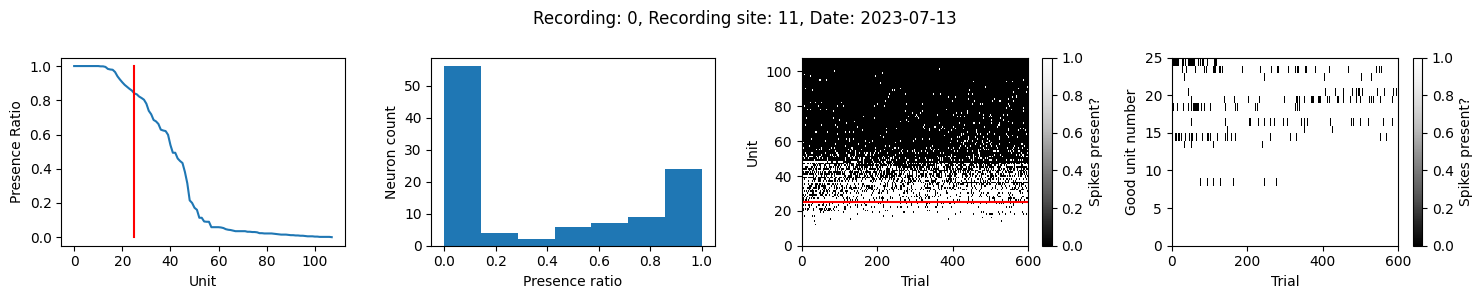

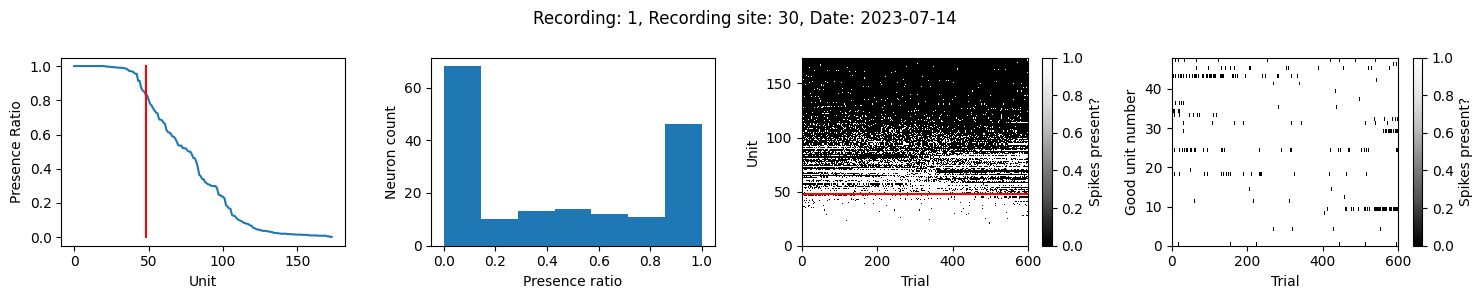

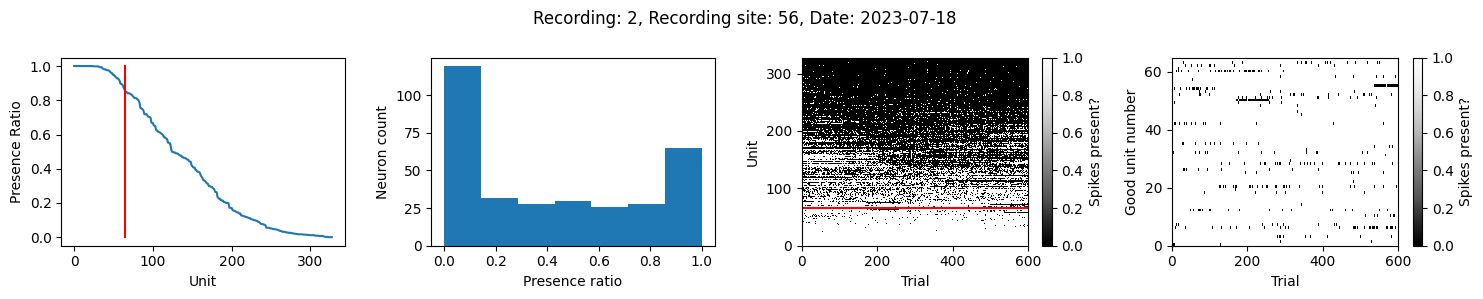

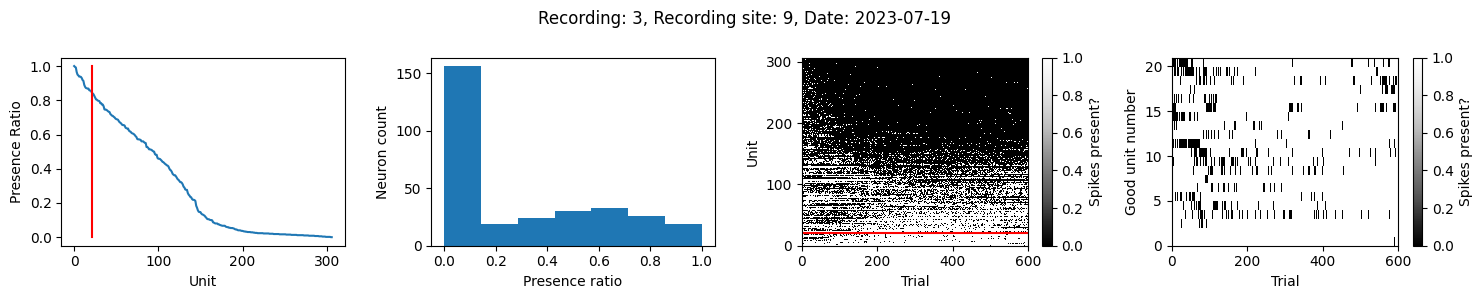

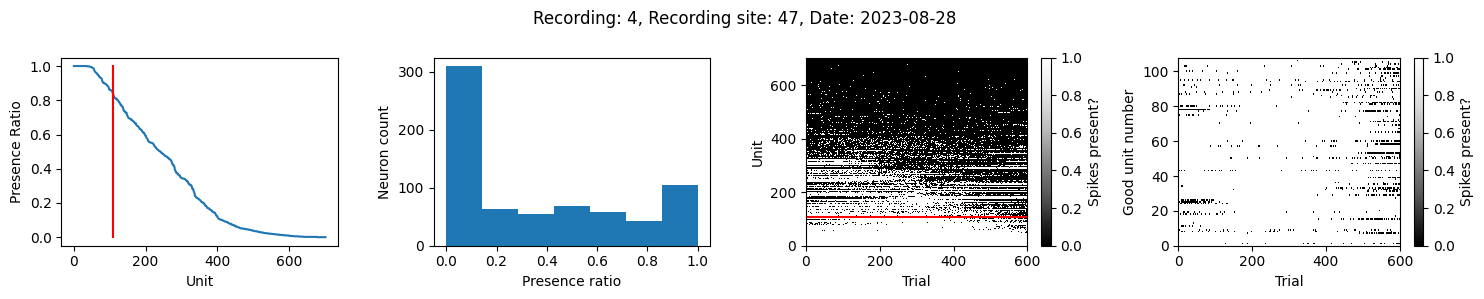

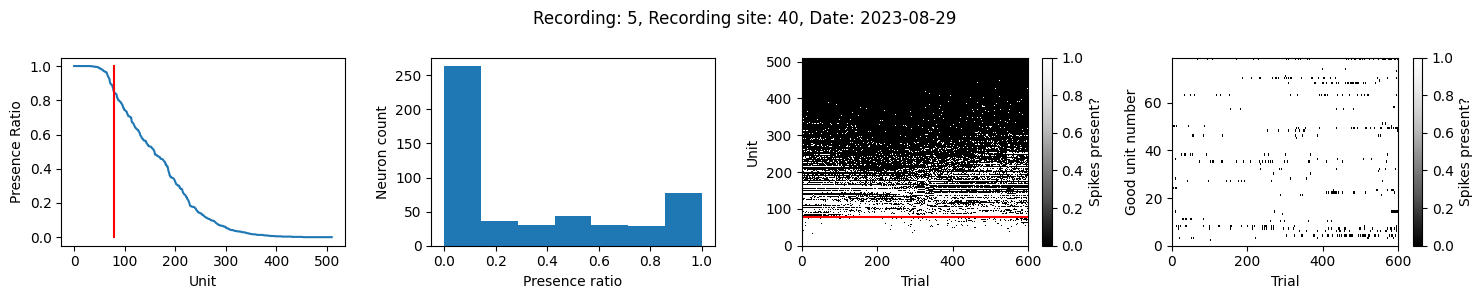

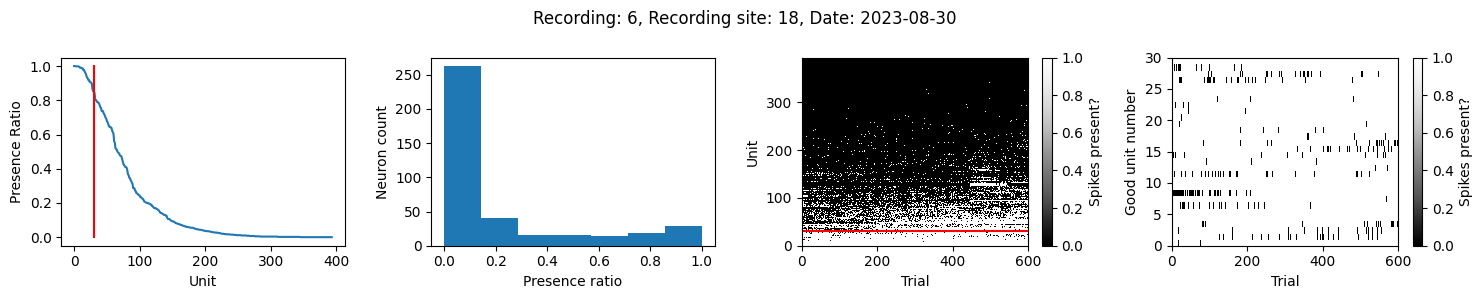

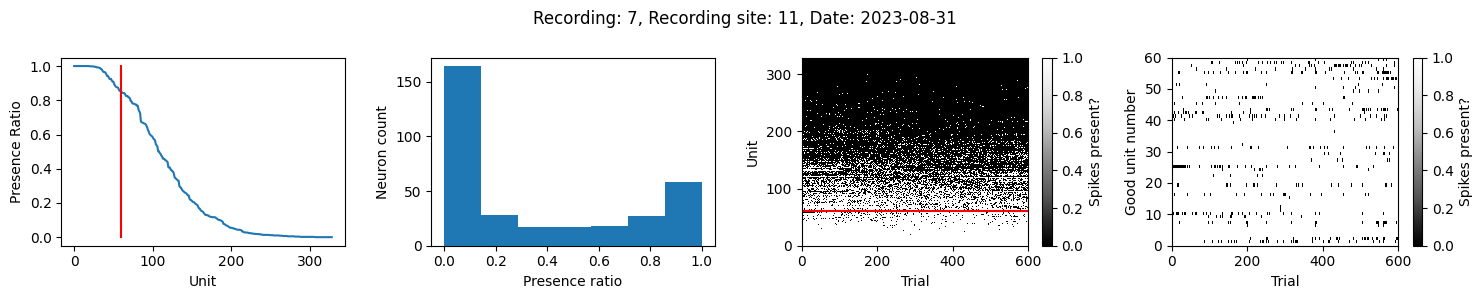

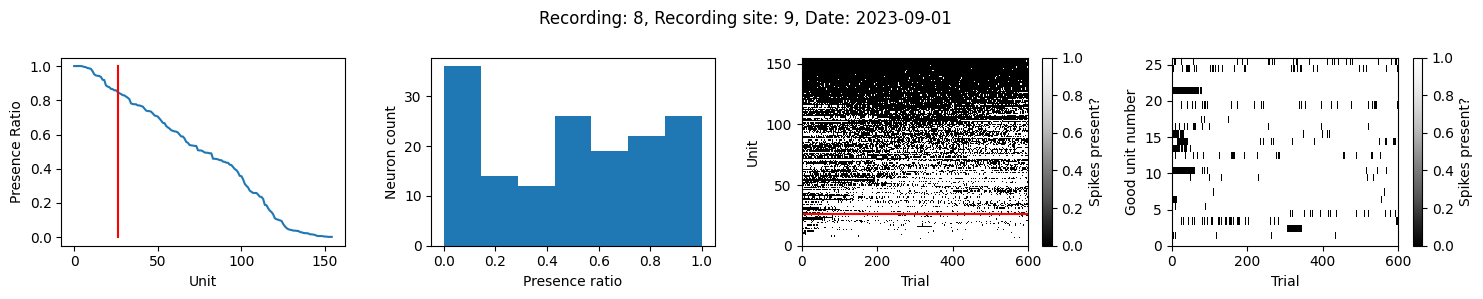

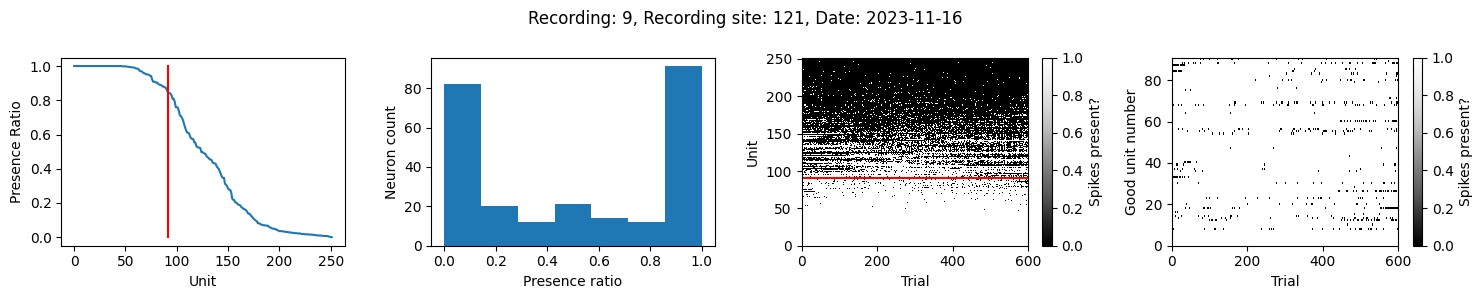

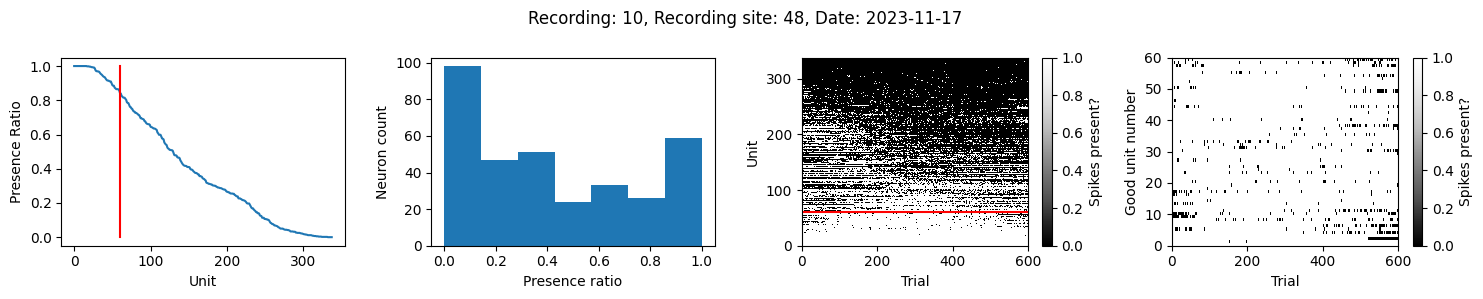

In [159]:
quality_metrics['presence_ratio'] = []
quality_metrics['present_units'] = []
quality_metrics['present_unit_labels'] = []
for irec in range(nrecs):
    presence_ratio, present_units, presence_details = calc_presence_ratio(np_data[align_events[-1]]['spike_align'][irec], min_trial_prop=min_trial_prop, return_details=True)
    ntrials = np_data[align_events[-1]]['spike_align'][irec].shape[1]
    
    fig, ax = plt.subplots(1,4,figsize=(15,3))
    ax[0].plot(presence_ratio[np.flip(np.argsort(presence_ratio))])
    ax[0].plot([np.sum(present_units), np.sum(present_units)], [0,1], 'r', label='Neuron cutoff')
    ax[0].set(xlabel='Unit', ylabel='Presence Ratio')
    
    ax[1].hist(presence_ratio, bins=int(np.round(1/(1-min_trial_prop))))
    ax[1].set(xlabel='Presence ratio', ylabel='Neuron count')
    
    pdetails_im = ax[2].pcolor(presence_details[:,np.flip(np.argsort(presence_ratio))].T,cmap='Greys_r')
    ax[2].plot([0, ntrials], [np.sum(present_units), np.sum(present_units)], 'r', label='Neuron cutoff')
    ax[2].set(xlabel='Trial', ylabel='Unit')
    cb = plt.colorbar(pdetails_im, label='Spikes present?')
              
    # np_data[align_events[-1]]['unit_labels'][irec]
    pdetails_im = ax[3].pcolor(presence_details[:,present_units].T,cmap='Greys_r')
    yaxis_unit_labels = np_data[align_events[-1]]['unit_labels'][irec][present_units]
    ax[3].set(xlabel='Trial', ylabel='Good unit number')
    cb = plt.colorbar(pdetails_im, label='Spikes present?')
        
    plt.suptitle(f"Recording: {irec}, Recording site: {recording_site[irec]}, Date: {dates[irec]}")
    fig.tight_layout()
    plt.show()
    
    quality_metrics['presence_ratio'].append(presence_ratio)
    quality_metrics['present_units'].append(present_units)
    quality_metrics['present_unit_labels'].append(np_data[align_events[-1]]['unit_labels'][irec][present_units])

## Firing Rate

In [14]:
from statsmodels.stats.multitest import fdrcorrection
def get_stable_FR_units(data, wind_size=17, alpha=0.05, correction='bonferroni', return_significance=False):
    '''
    Args:
        data (ntime, ntrial, nunit): Binned and trial aligned firing rate
        wind_size (int): Size of rolling average window [trials] used to smooth firing rate. Typically large enough to average out any tuning seen by a neuron
        alpha (float): significance level
        correction (string): Type of multiple comparison correction to do ('bonferroni' or 'fdr') 
        return_significance (bool): If the linear fit significance should be returned 
    '''        
    ntime, ntrials, nunits = data.shape
    
    avg_fr_each_trial = np.mean(data, axis=0)
    smooth_avg_fr_each_trial = aopy.analysis.base.calc_rolling_average(avg_fr_each_trial, window_size=17) # move window size to input args
    
    # # stable_units = np.std(smooth_avg_fr_each_trial/(np.max(smooth_avg_fr_each_trial,axis=0)-np.min(smooth_avg_fr_each_trial,axis=0)), axis=0) < 0.25 # move threshold to input args
    pccs = []
    [pccs.append(aopy.analysis.base.linear_fit_analysis2D(np.arange(ntrials), smooth_avg_fr_each_trial[:,iunit])[3]) for iunit in range(nunits)]
    
    if correction == 'bonferroni':
        stable_units = np.array(pccs) > (0.05/nunits)
    elif correction == 'fdr':
        stable_units = np.logical_not(fdrcorrection(np.array(pccs), alpha=0.05)[0])
    else:
        print('Please enter a valid multiple comparison method')
        
    if return_significance:
        return stable_units, np.array(pccs)
    else:
        return stable_units

In [53]:
fr_trial_window_size=17
quality_metrics['stable_fr_units'] = []
quality_metrics['stable_fr_units_pcc'] = []
for irec in range(nrecs):
    _, present_units = calc_presence_ratio(np_data[align_events[-1]]['spike_align'][irec], min_trial_prop=0.3, return_details=False) # set a low minimum trial threshold so neurons with very few spikes aren't used
    
    stable_units, pccs =  get_stable_FR_units(np_data[align_events[-1]]['spike_align'][irec][:,:,present_units], wind_size=17, alpha=0.01, correction='fdr', return_significance=True)
    
    quality_metrics['stable_fr_units'].append(np.where(present_units)[0][stable_units])
    quality_metrics['stable_fr_units_pcc'].append(pccs[stable_units])

In [56]:
print(f"Number of stable units in each recording: {[len(quality_metrics['stable_fr_units'][irec]) for irec in range(nrecs)]}")

Number of stable units in each recording: [4, 5, 11, 10, 6, 10, 3, 11, 5, 15, 8]


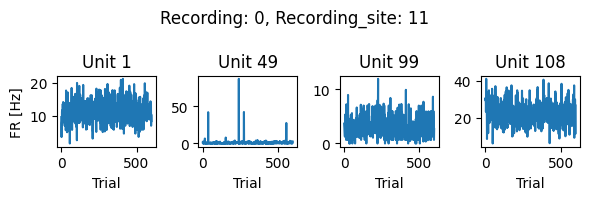

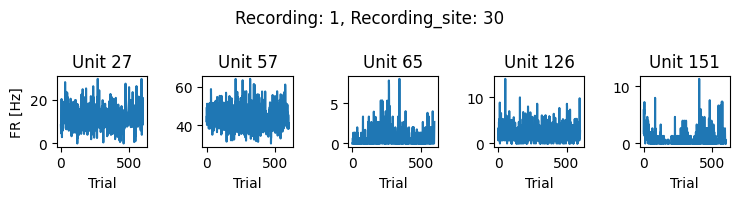

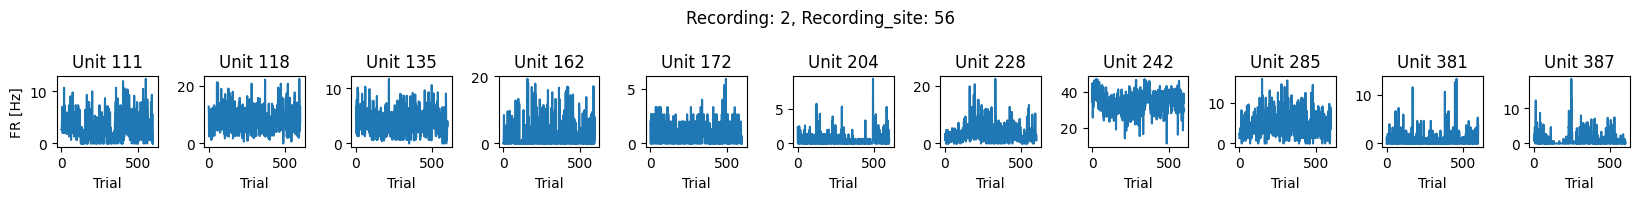

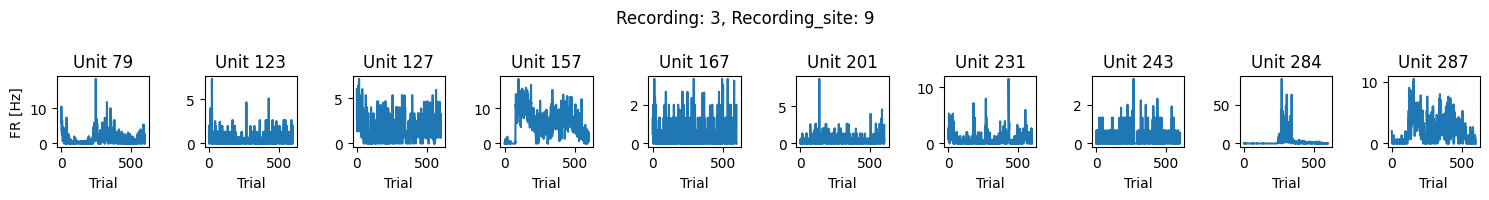

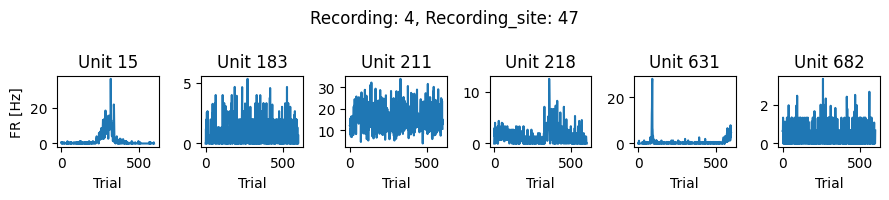

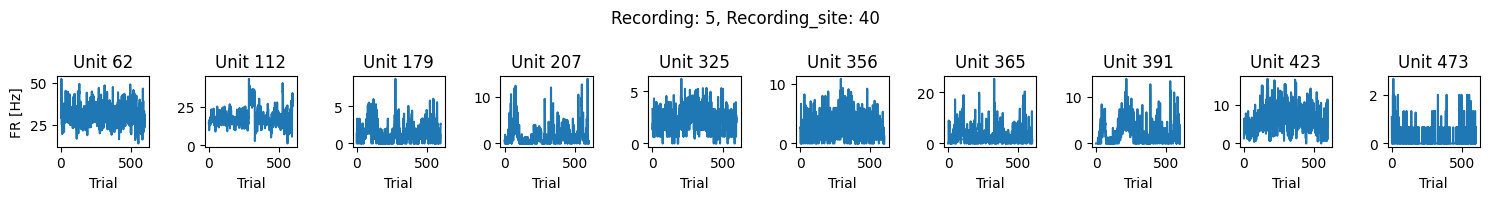

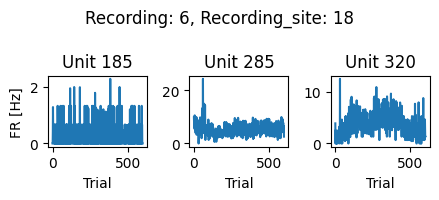

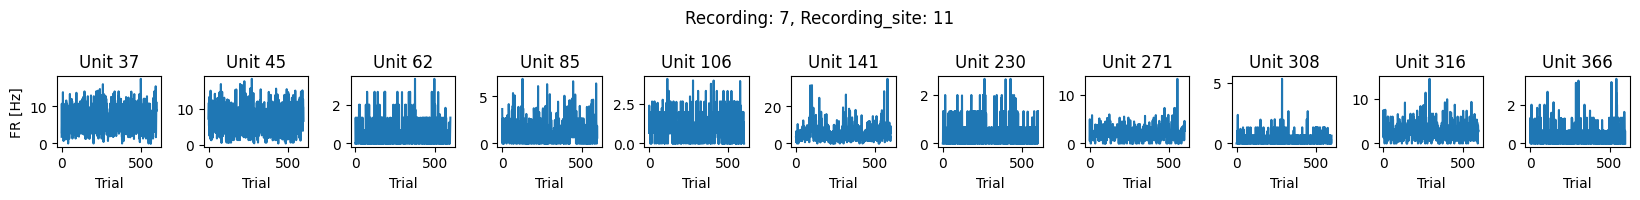

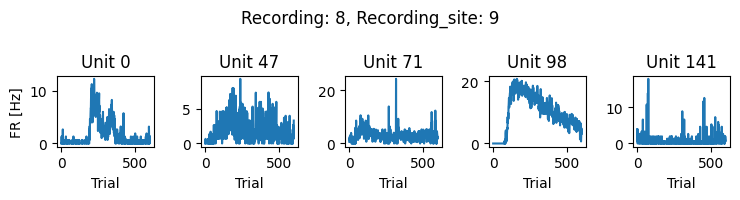

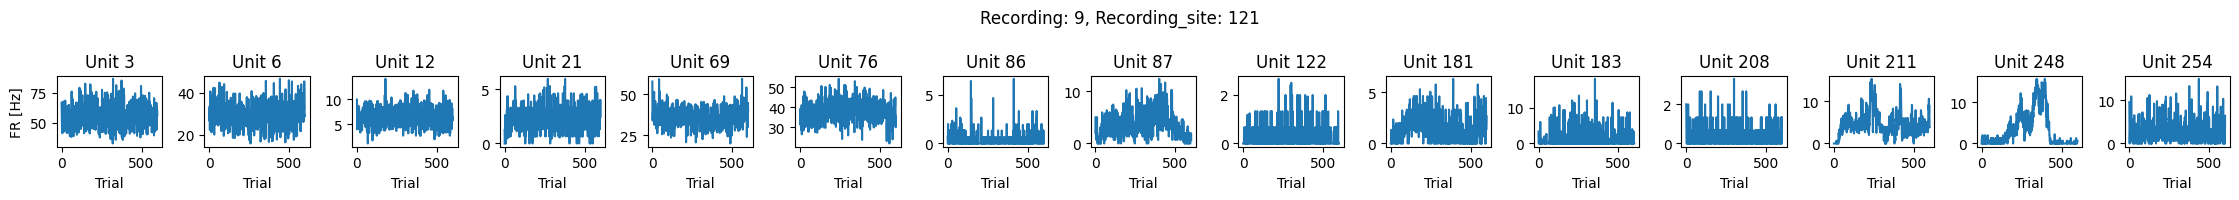

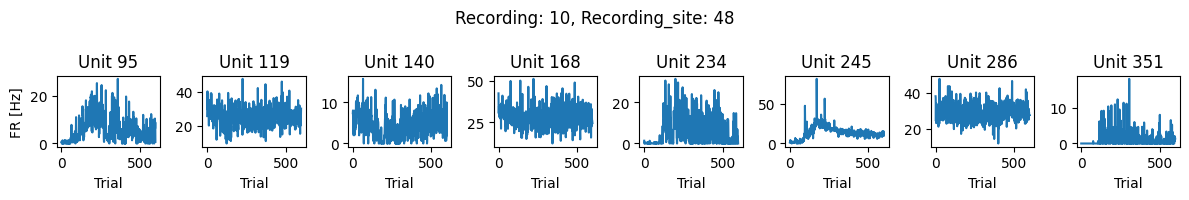

In [115]:
for irec in range(nrecs):
    nstable_units = len(quality_metrics['stable_fr_units'][irec])
    fig, ax = plt.subplots(1,nstable_units,figsize=(nstable_units*1.5,2))
    [ax[iax].plot(np.mean(np_data[align_events[-1]]['spike_align'][irec], axis=0)[:,quality_metrics['stable_fr_units'][irec][iax]]) for iax in range(len(ax))]
    ax[0].set(ylabel='FR [Hz]')
    [ax[iax].set(xlabel='Trial', title=f"Unit {np_data[align_events[-1]]['unit_labels'][irec][quality_metrics['stable_fr_units'][irec][iax]]}") for iax in range(len(ax))]
    # np_data[align_events[-1]]['unit_labels'][0]
    plt.suptitle(f"Recording: {irec}, Recording_site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

## ISI Violations

In [133]:
def get_units_without_refractory_violations(preproc_dir, subject, te_id, date, ref_perc_thresh=0.01, min_ref_period=1):
    '''
    Load data directly from kilosort output to find units with refractory period violations
    
    Args:
        preproc_dir (str): 
        date:
        te:
        subject:
        min_ref_period (float): [ms]
        
    Returns: 
        good_unit_labels:        
    '''
    filename = aopy.data.get_preprocessed_filename(subject, te_id, date, 'ap')
    ap_data = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename, 'ap')
    nunits = len(ap_data['unit'].keys())
    
    ref_violations = np.zeros(nunits)*np.nan
    good_unit_labels = []
    for iunit, unit_lbl in enumerate(list(ap_data['unit'].keys())):
        nspikes = len(ap_data['unit'][unit_lbl])
        ref_violations[iunit] = np.sum(np.diff(ap_data['unit'][unit_lbl]) < (min_ref_period/1000)) # convert from [ms] to [s]
        
        if (ref_violations[iunit]/nspikes) <= ref_perc_thresh:
            good_unit_labels.append(unit_lbl)
    
    return good_unit_labels, ref_violations

In [134]:
irec = 1
temp_date = np_data[align_events[-1]]['mc_entries'][irec].date.date()
temp_id = np_data[align_events[-1]]['mc_entries'][irec].id
subject = 'beignet'
gul, rv = get_units_without_refractory_violations(data_path_preproc, subject, temp_id, temp_date)

In [147]:
quality_metrics['ISI_threshold_units'] = []
for idate, date in enumerate(tqdm(dates)):
    within_day_mc_entries = [me for me in np_data[align_events[-1]]['mc_entries'] if me.date.date() == date]
    temp_cnt = 0
    for ime, me in enumerate(within_day_mc_entries):
        # Load data
        filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'ap')
        try:
            ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')

        except:
            continue
            
        # find units that pass refractory violation threshold
        temp_good_unit_labels, _ = get_units_without_refractory_violations(data_path_preproc, subject, me.id, me.date.date())
        
        if temp_cnt == 0:
            good_unit_labels = np.array(temp_good_unit_labels) 
        else:
            good_unit_labels = good_unit_labels[np.in1d(good_unit_labels, np.array(temp_good_unit_labels))]
        
        temp_cnt += 1
    
    # only use units that pass for all recordings
    quality_metrics['ISI_threshold_units'].append(good_unit_labels)

  0%|          | 0/11 [00:00<?, ?it/s]

## Amplitude threshold

In [111]:
print(ap_metadata.keys())
gain = ap_metadata['apGainValue']
nwf = 25 # Number of waveforms to load for each cluster
amp_thresh = 50 # Median amplitude threshold [uV]
print(gain)

dict_keys(['apGainValue', 'bit_volts', 'bs_part_number', 'bs_serial_number', 'bsc_part_number', 'bsc_serial_number', 'ch_bank', 'channel', 'dock', 'headstage_part_number', 'headstage_serial_number', 'num_channels', 'port', 'probe_part_number', 'probe_serial_number', 'referenceChannel', 'sample_rate', 'slot', 'source_node_id', 'source_node_name', 'stream_name', 'sync_sample_rate', 'xpos', 'ypos'])
500x


# Apply all QC metrics

In [ ]:
def get_good_neuropixel_units(data, preproc):
    '''
    Args:
        data (ntime, ntrials, nunits):
        preproc_dic ():
        
    '''
    presence_ratio, present_units, presence_details = calc_presence_ratio(data, min_trial_prop=min_trial_prop, return_details=False)    
    stable_units, pccs =  get_stable_FR_units(data[:,:,present_units], wind_size=17, alpha=0.01, correction='fdr', return_significance=True)
    temp_good_unit_labels, _ = get_units_without_refractory_violations(data_path_preproc, subject, me.id, me.date.date())

In [290]:
quality_metrics['final_good_unit_labels'] = []
quality_metrics['final_good_unit_idx'] = []
for irec in range(nrecs):
    present_unit_mask = np.in1d(np.array(np_data[align_events[-1]]['unit_labels'][irec]), quality_metrics['present_unit_labels'][irec])
    stable_unit_mask = np.in1d(np.array(np_data[align_events[-1]]['unit_labels'][irec]), quality_metrics['stable_fr_units'][irec])
    isi_good_unit_mask = np.in1d(np.array(np_data[align_events[-1]]['unit_labels'][irec]), quality_metrics['ISI_threshold_units'][irec])
    
    # final_good_unit_labels_temp = present_unit_mask*stable_unit_mask*isi_good_unit_mask
    final_good_unit_labels_temp = present_unit_mask*isi_good_unit_mask
    
    if np.sum(final_good_unit_labels_temp) == 0:
        quality_metrics['final_good_unit_labels'].append([])
        quality_metrics['final_good_unit_idx'].append([])
    else:
        print(np.where(final_good_unit_labels_temp)[0])
        quality_metrics['final_good_unit_labels'].append(np_data[align_events[-1]]['unit_labels'][irec][np.where(final_good_unit_labels_temp)[0]])
        quality_metrics['final_good_unit_idx'].append(np.where(final_good_unit_labels_temp)[0])

[ 1  3 14 17 26 28 33 34 40 43 44 48 53 54 58 59 62 65 67 73 76 89 90 99]
[  8   9  11  12  14  15  17  19  20  23  24  25  26  28  29  30  34  35
  39  41  46  48  49  52  62  63  65  67  68  70  71  73  74  75  78  85
  86  87  89  96  97  98 101 102 111 115 123 141]
[  0  22  24  25  33  43  47  59  61  62  65  66  67  71  72  73  74  77
  80  81  86  87  89  90  92  95  97 101 103 104 105 109 113 114 117 122
 123 124 127 129 138 146 165 169 173 174 179 189 211 230 235 237 246 250
 284]
[ 28  29  48  53  54 100 101 103 113 115 127 140 157 173 180 190 201 219
 220 235 256]
[ 22  34  35  39  51  53  55  56  58  59  61  62  63  73  77  80  81  83
  86  90  93  97  98 101 102 108 113 114 119 123 125 127 132 138 139 141
 144 145 147 160 161 164 167 168 176 177 198 204 205 206 215 227 228 231
 243 248 250 253 254 256 257 263 266 274 284 290 299 327 357 385 387 406
 408 410 411 413 421 425 431 436 442 452 453 456 459 461 467 476 479 493
 510 525 531 532 541 548 583 592 606 628 680]
[ 33  3

In [282]:
print(irec_wfs.keys())

dict_keys(['21', '25', '26', '34', '38', '49', '62', '69', '71', '75', '83', '98', '100', '105', '106', '108', '111', '118', '119', '121', '122', '124', '126', '128', '130', '135', '137', '139', '140', '143', '148', '151', '152', '153', '163', '168', '175', '182', '189', '192', '197', '199', '202', '205', '212', '213', '226', '231', '245', '248', '253', '279', '294', '307', '384'])


## Plot waveforms of units that pass QC metrics

  0%|          | 0/11 [00:00<?, ?it/s]

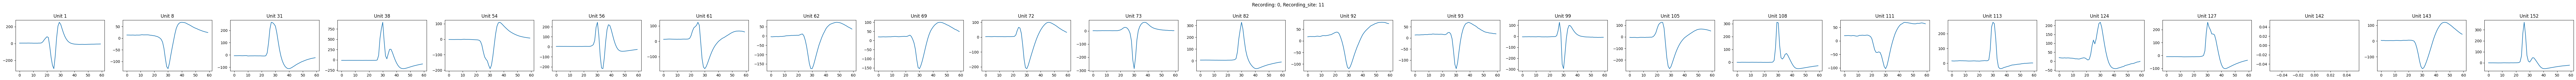

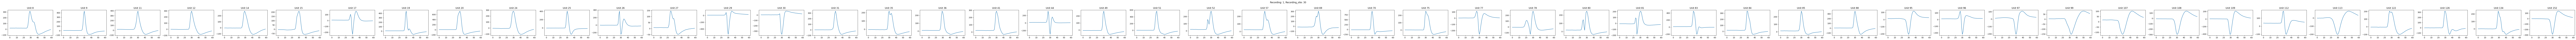

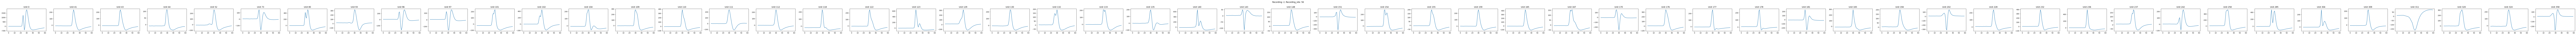

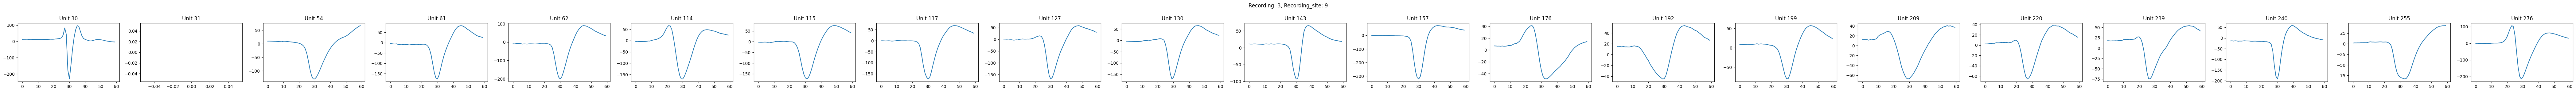

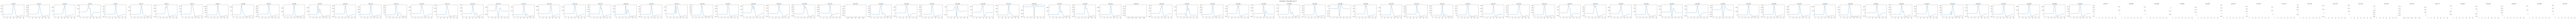

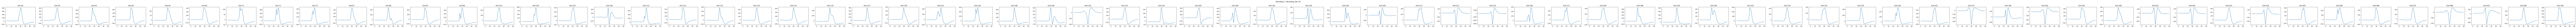

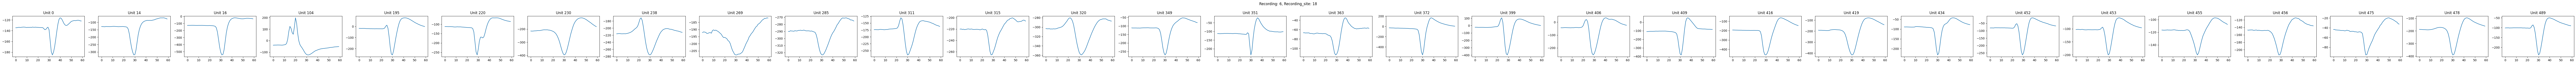

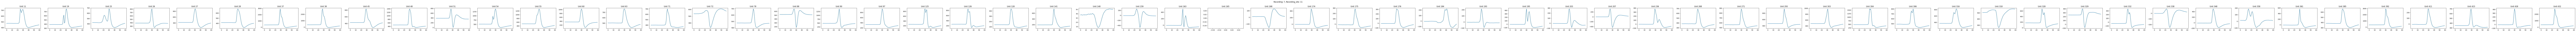

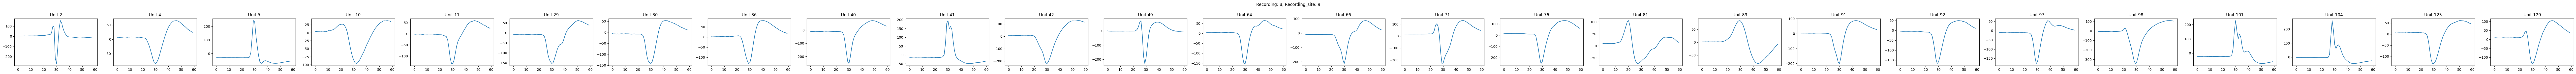

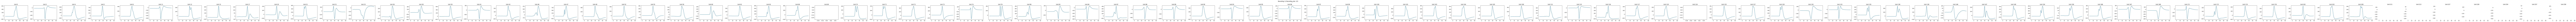

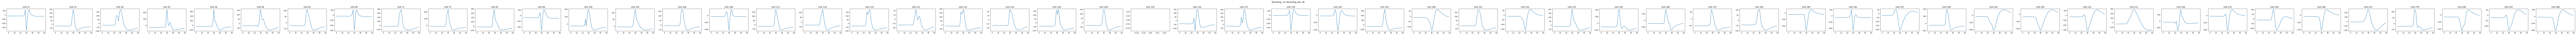

In [247]:
# Go back and load waveforms from the originally preprocessed neuropixel data
quality_metrics['mean_wfs'] = []
quality_metrics['position'] = []
for idate, date in enumerate(tqdm(dates)):
    if len(quality_metrics['final_good_unit_labels'][idate]) > 0:
        within_day_mc_entries = [me for me in np_data[align_events[-1]]['mc_entries'] if me.date.date() == date]

        irec_wfs = {}
        irec_pos = {}
        temp_cnt = 0
        for ime, me in enumerate(within_day_mc_entries):
            # Load data
            filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'ap')
            try:
                ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')

            except:
                continue

            # concatenate data
            ngoodunits = len(quality_metrics['final_good_unit_labels'][idate])
            for goodunit_label in quality_metrics['final_good_unit_labels'][idate]:
                if temp_cnt == 0:
                    irec_wfs[str(goodunit_label)] = ap_data['waveform'][str(goodunit_label)]
                    irec_pos[str(goodunit_label)] = ap_data['pos'][str(goodunit_label)]
                else:
                    irec_wfs[str(goodunit_label)] = np.concatenate((irec_wfs[str(goodunit_label)], ap_data['waveform'][str(goodunit_label)]), axis=0)

            temp_cnt += 1

        # plot waveforms 
        fig, ax = plt.subplots(1,ngoodunits, figsize=(ngoodunits*4,3))
        mean_wfs = np.zeros((len(quality_metrics['final_good_unit_labels'][idate]),60))*np.nan
        unit_pos = np.zeros((len(quality_metrics['final_good_unit_labels'][idate])))*np.nan
        for igoodunit, goodunit_label in enumerate(quality_metrics['final_good_unit_labels'][idate]):
            max_ch = np.argmax(np.max(np.mean(irec_wfs[str(goodunit_label)], axis=0), axis=0))
            mean_wf_temp = np.mean(irec_wfs[str(goodunit_label)][:,:,max_ch], axis=0)
            mean_wfs[igoodunit, :] = mean_wf_temp
            unit_pos[igoodunit] = irec_pos[str(goodunit_label)][1]
            if len(quality_metrics['final_good_unit_labels'][idate]) > 1:
                ax[igoodunit].plot(mean_wf_temp)
                ax[igoodunit].set(title=f"Unit {goodunit_label}")
            else:
                ax.plot(mean_wf_temp)
                ax.set(title=f"Unit {goodunit_label}")
        plt.suptitle(f"Recording: {idate}, Recording_site: {recording_site[idate]}")
        fig.tight_layout()
        plt.show()
        
        quality_metrics['mean_wfs'].append(mean_wfs)
        quality_metrics['position'].append(unit_pos)
    else:
        quality_metrics['mean_wfs'].append([])

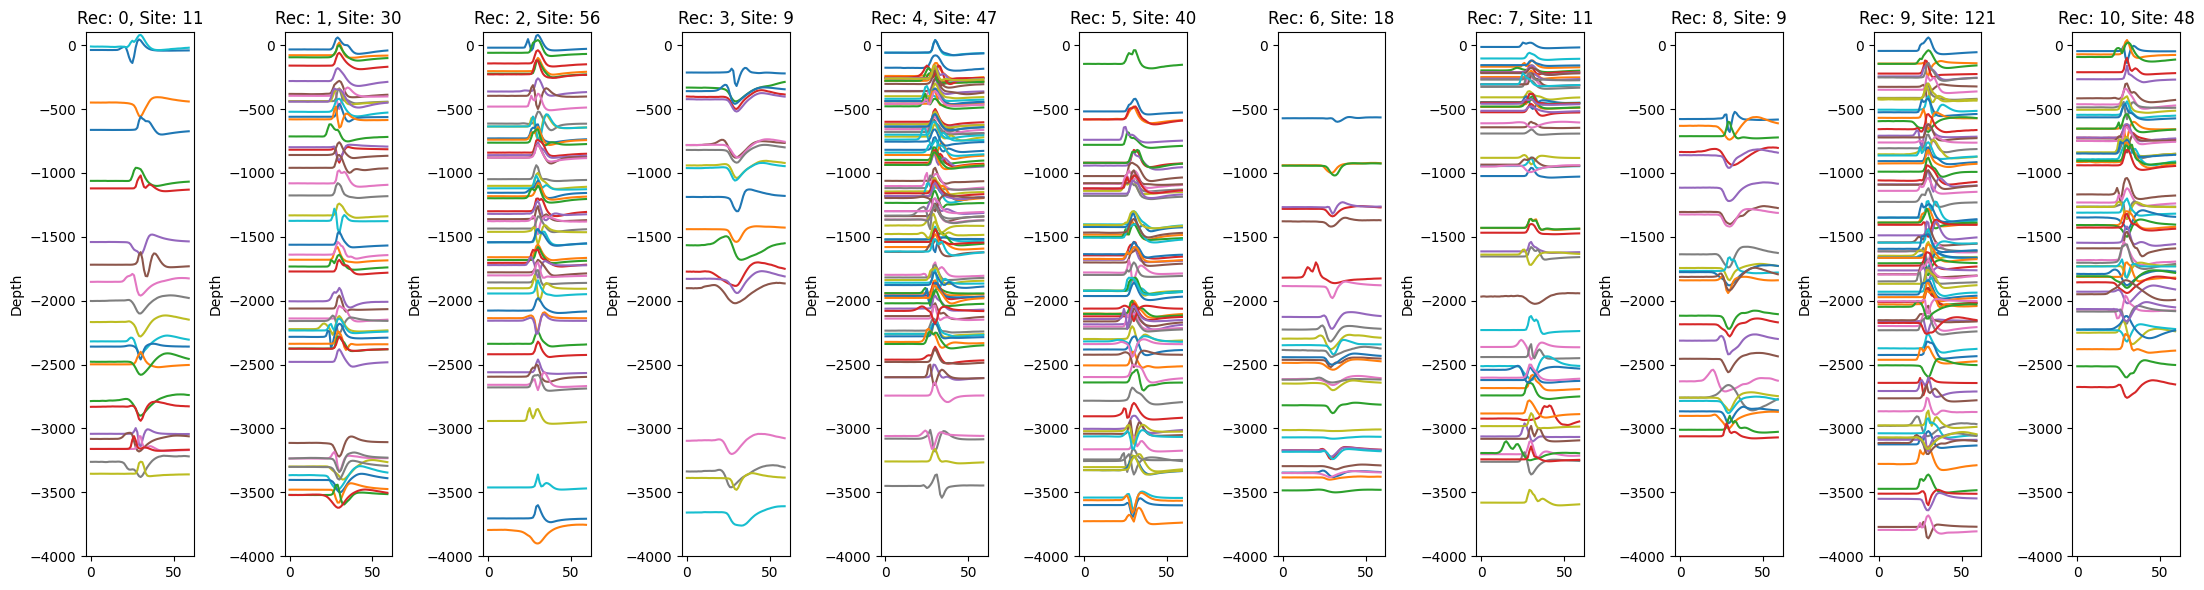

In [275]:
fig, ax = plt.subplots(1,nrecs,figsize=(2*nrecs,6))
for irec in range(nrecs):
    
    for iunit in range(len(quality_metrics['mean_wfs'][irec])):
        norm_wf = 100*quality_metrics['mean_wfs'][irec][iunit,:]/np.max(np.abs(quality_metrics['mean_wfs'][irec][iunit,:]))
        ax[irec].plot(norm_wf - quality_metrics['position'][irec][iunit])
    
    ax[irec].set(title=(f"Rec: {irec}, Site: {recording_site[irec]}"), ylabel='Depth', ylim=(-4000,100))
fig.tight_layout()
plt.show()

## Save QC results

In [291]:
start = time.time()
aopy.data.base.pkl_write(f"{subject}_QCunits", quality_metrics, save_dir)
print(time.time()-start)

0.015631675720214844


In [292]:
start = time.time()
test = aopy.data.base.pkl_read(f"{subject}_QCunits", save_dir)
print(time.time()-start)

0.00965261459350586


In [293]:
print(test.keys())

dict_keys(['presence_ratio', 'present_units', 'stable_fr_units', 'stable_fr_units_pcc', 'ISI_threshold_units', 'present_unit_labels', 'final_good_unit_labels', 'mean_wfs', 'position', 'final_good_unit_idx'])


# Find segments of trials for each unit that pass QC metrics